# Importação das bibliotecas necessárias

In [141]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from pandas_profiling import ProfileReport
from unidecode import unidecode

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_roc_curve
from skopt import BayesSearchCV
import lime
import lime.lime_tabular

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score


# Leitura do Documento

In [2]:
df = pd.read_excel('../data/carteira_total.xlsx')

# Pandas Proffling

In [3]:
# prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

# EDA

Remoção dos acentos das colunas e alteração dos caracteres diferentes de alfa numérico para "_"

In [4]:
newColumnsName = []
for column_name in df:
  newColumnsName.append(re.sub('[^A-Za-z0-9]+', '_', unidecode(column_name).lower()))
df.columns = newColumnsName

Criação da coluna churn, e definição do seu valor com base nos valores da coluna upsale_downsale (churn = 1, demais valores = 0). Decidimos excluir a coluna upsell_downsell (por não ter mais importância para a análise)

In [5]:
df["upsale_downsale"].replace({"Churn": "churn", "Upsell": "upsell", "Downsell": "downsell", "Ok": "ok"}, inplace=True)
df['churn'] = df['upsale_downsale']
df['churn'].replace({"ok": "0", "upsell": "0", "downsell": "0", "churn": "1"}, inplace=True)
df['churn'] = df['churn'].astype(int)

df.drop(columns = ["upsale_downsale"], inplace = True)

In [6]:
df.dtypes

mes                           datetime64[ns]
id_crm                                 int64
id_navplat                             int64
id_sap                                 int64
regiao                                object
cidade                                object
bairro                                object
valor_mensal                         float64
valor_hoje                           float64
faturamento                          float64
oficina                               object
frequencia_de_faturamento             object
tipo_de_plano                         object
contratado_super_destaques             int64
contratado_destaques                   int64
contratado_ofertas_simples             int64
contratado_freemium                  float64
utilizado_super_destaques            float64
utilizado_destaque                   float64
utilizado_ofertas_simples            float64
utilizado_freemium                   float64
executivo_carteira_atual              object
equipe    

In [7]:
# Missing Values
# contratado_freemium (52.1%) - Quantidade de zeros (25.9%)
# utilizado_freemium (52.1%) - Quantidade de zeros (44.5%)

# possui_midia_ativa_ (0.6%) - categorica
# custo_por_lead_total (0.4%)
# total_contratado (0.4%)
# utilizado_super_destaques (< 0.1%)
# utilizado_destaque (< 0.1%)
# utilizado_ofertas_simples (< 0.1%)
# leads_form (< 0.1%)
# leads_ver_dato (< 0.1%)
# leads_total (< 0.1%)
# custo_por_listing (< 0.1%)
# total_utilizado (< 0.1%)
# faixa_listings (< 0.1%) - categorica

## Padronizando valores categóricos

### Oficina

In [8]:
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

In [9]:
df['oficina'].replace({'wi': 'WI'}, inplace=True) # Alterando o valor wi para igualar a WI
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

### Faturamento

In [10]:
df['frequencia_de_faturamento'].unique()

array(['Mensal', 'Anual', 'Semestral', 'Trimestral', 'MENSAL', 'ANUAL',
       'SEMESTRAL', 'TRIMESTRAL', 0], dtype=object)

In [11]:
#corrigir diferenças de nomes
df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.lower()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', nan], dtype=object)

In [12]:
#remover espaços

df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.strip()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', nan], dtype=object)

In [13]:
#renomeando unica vez

df['frequencia_de_faturamento'].replace({'única vez': 'unica_vez'}, inplace=True)
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', nan], dtype=object)

### Tipo de Plano

In [14]:
df['tipo_de_plano'].unique()

array(['LIMITADO', 'ILIMITADO', nan, 'SIMPLES', 'PACK', 0], dtype=object)

### Midia Ativa

In [15]:
df['possui_midia_ativa_'].unique()

array(['No', 'Si', nan], dtype=object)

### PF_PJ

In [16]:
df['pf_pj'].unique()

array(['PJ', 'PF'], dtype=object)

### Equipe

In [17]:
df['equipe'].unique()

array(['Regional DF', 'Relacionamento', 'JUMBO', 'Resellers', 'Jumbo',
       'Mídias', 'RELACIONAMENTO', 'RESELLERS', 'REGIONAL DF'],
      dtype=object)

In [18]:
df['equipe'].replace({'Relacionamento': 'RELACIONAMENTO','Jumbo':'JUMBO','Resellers':'RESELLERS'}, inplace=True) # Alterando para valores ficarem iguais
df['equipe'].unique()

array(['Regional DF', 'RELACIONAMENTO', 'JUMBO', 'RESELLERS', 'Mídias',
       'REGIONAL DF'], dtype=object)

In [19]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano',
       'contratado_super_destaques', 'contratado_destaques',
       'contratado_ofertas_simples', 'contratado_freemium',
       'utilizado_super_destaques', 'utilizado_destaque',
       'utilizado_ofertas_simples', 'utilizado_freemium',
       'executivo_carteira_atual', 'equipe', 'status_final',
       'possui_midia_ativa_', 'leads_form', 'leads_ver_dato', 'leads_total',
       'custo_por_lead_total', 'total_contratado', 'total_de_listings',
       'custo_por_listing', 'pf_pj', 'total_utilizado', 'faixa_listings',
       'churn'],
      dtype='object')



---



## Drop das colunas "contratado_freemium" e "utilizado_freemium" por possuírem diversos valores nulos e zerados

In [20]:
df.drop(['contratado_freemium', 'utilizado_freemium'], axis=1, inplace=True)

## Analise Grafica

### Análise região (não aparenta influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


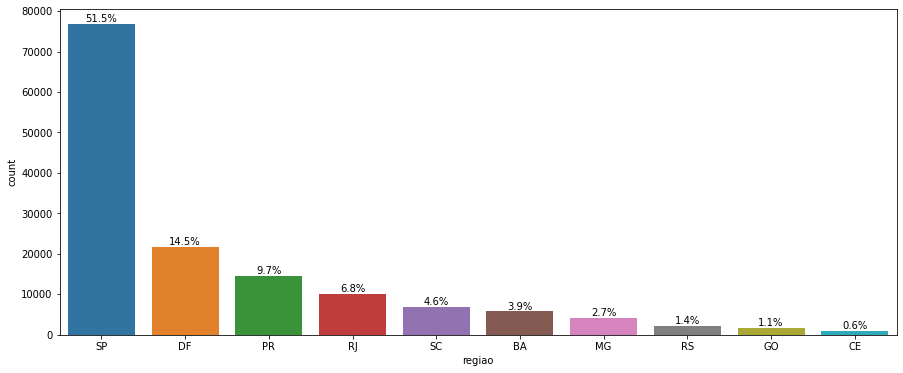

In [21]:
serie_filtrada = df["regiao"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


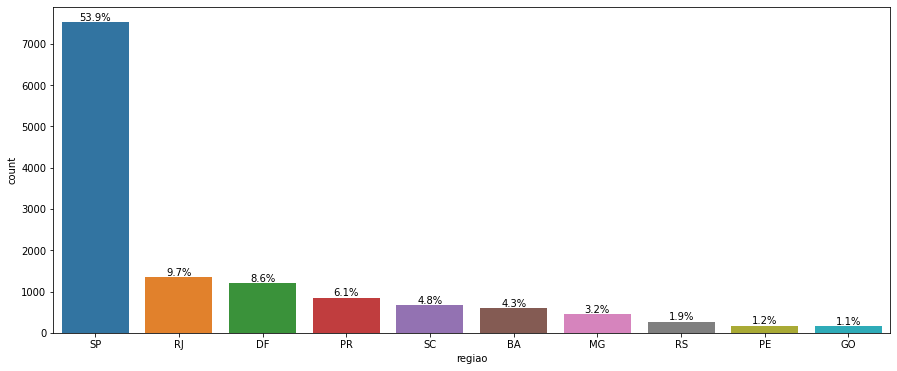

In [22]:
serie_filtrada = df[df["churn"] == 1]["regiao"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Cidade (não aparenta influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


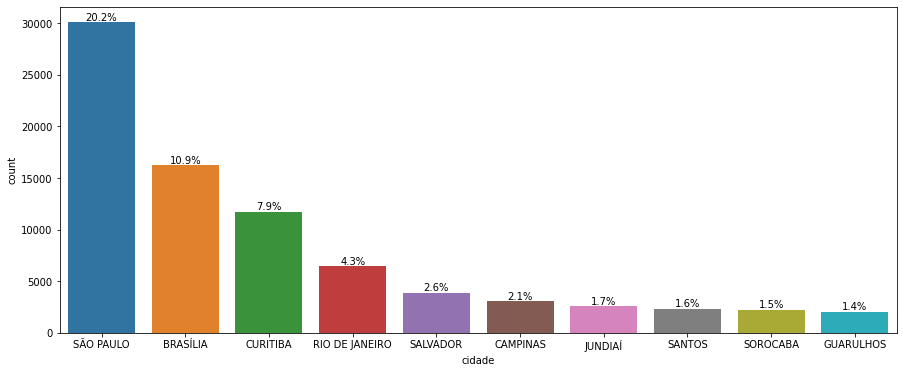

In [23]:
serie_filtrada = df["cidade"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


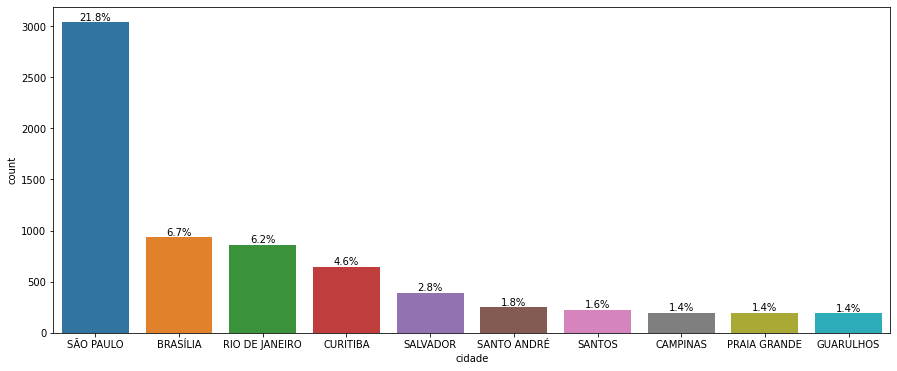

In [24]:
serie_filtrada = df[df["churn"] == 1]["cidade"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Oficina (não aparenta influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


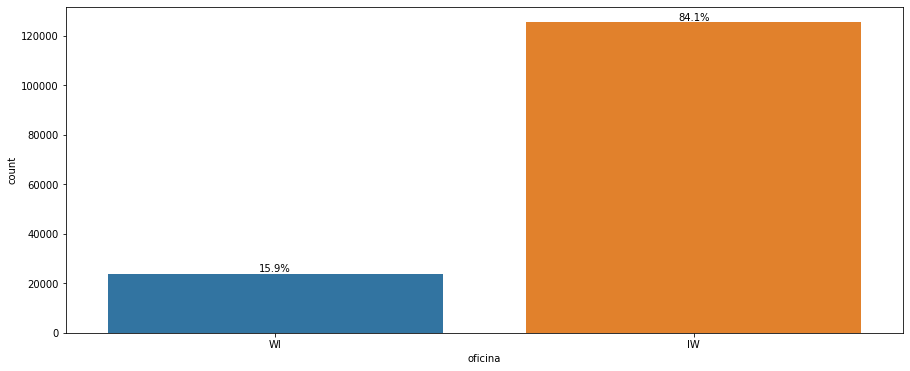

In [25]:
serie_filtrada = df["oficina"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


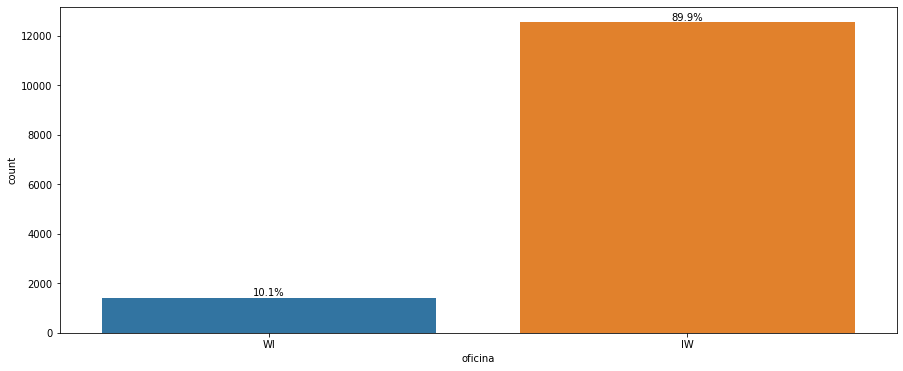

In [26]:
serie_filtrada = df[df["churn"] == 1]["oficina"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Frequência Faturamento (não aparenta influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


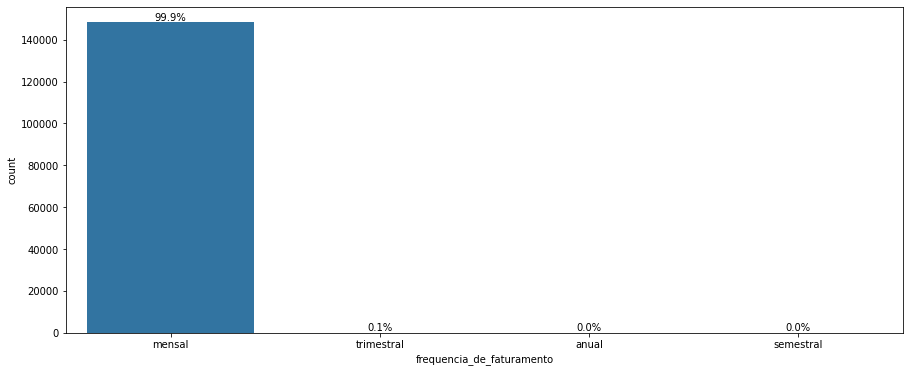

In [27]:
serie_filtrada = df["frequencia_de_faturamento"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


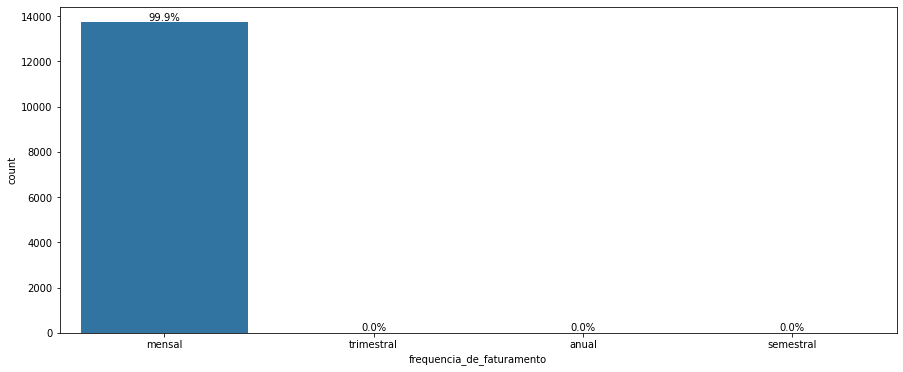

In [28]:
serie_filtrada = df[df["churn"] == 1]["frequencia_de_faturamento"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Tipo de Plano (pode influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


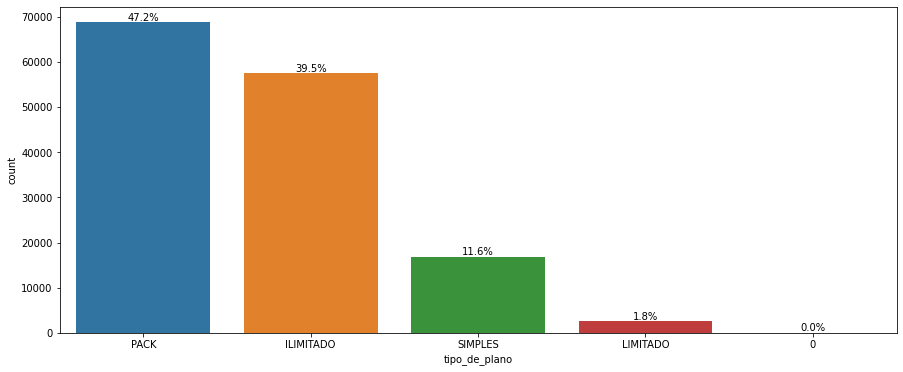

In [29]:
serie_filtrada = df["tipo_de_plano"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


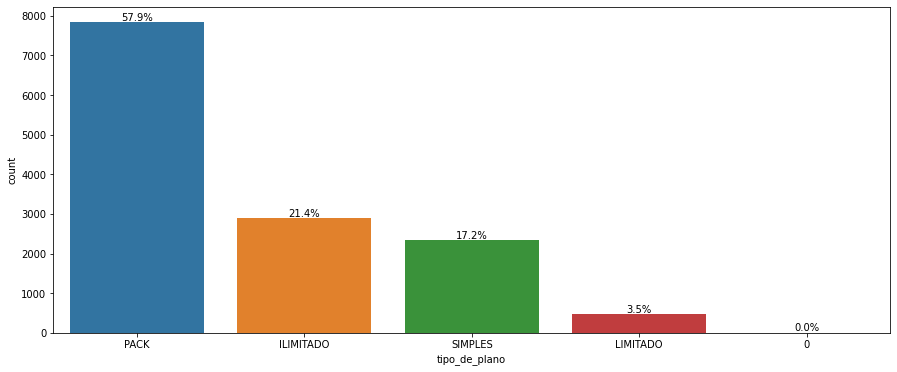

In [30]:
serie_filtrada = df[df["churn"] == 1]["tipo_de_plano"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Executivo Carteira Atual (não aparenta influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


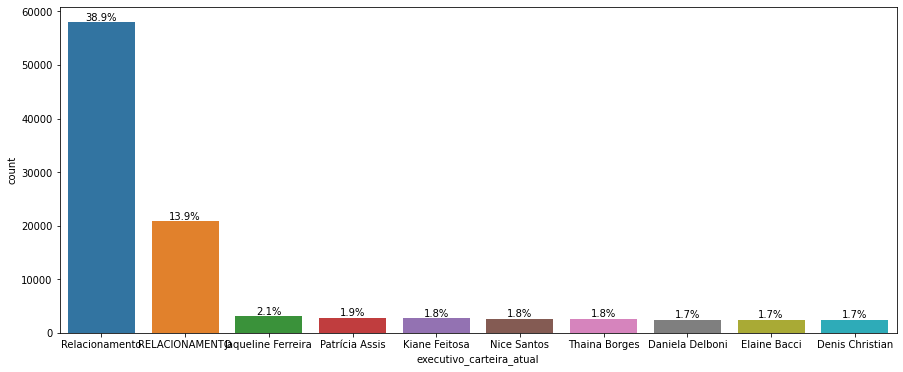

In [31]:
serie_filtrada = df["executivo_carteira_atual"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


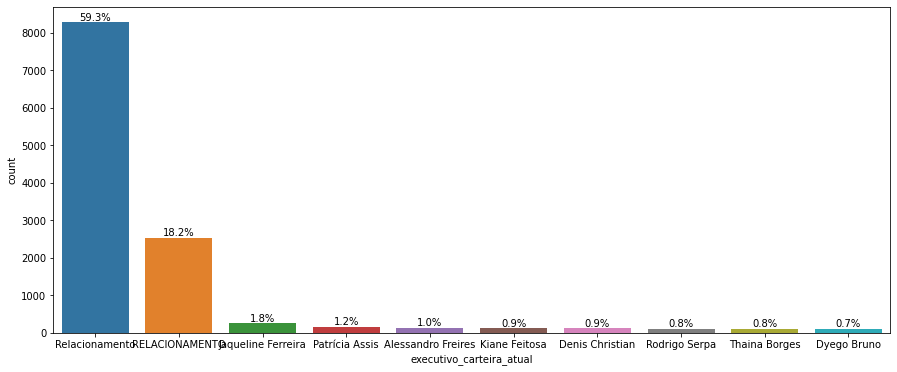

In [32]:
serie_filtrada = df[df["churn"] == 1]["executivo_carteira_atual"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Equipe (pode influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


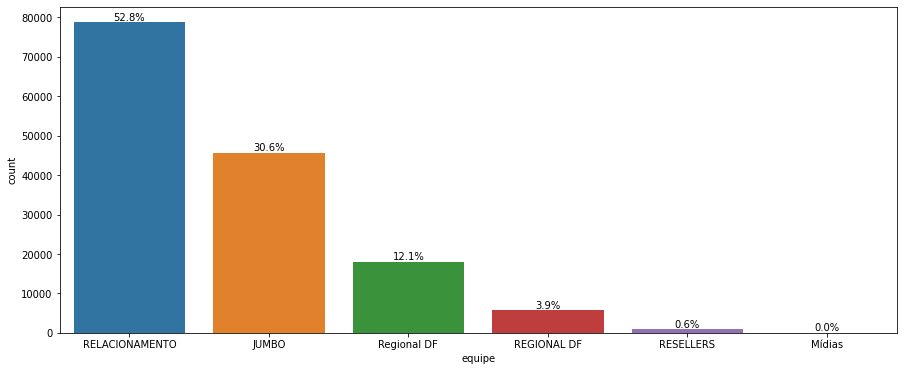

In [33]:
serie_filtrada = df["equipe"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


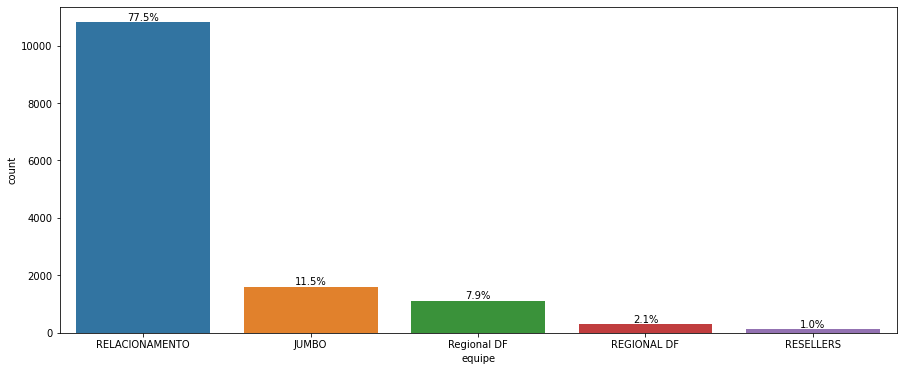

In [34]:
serie_filtrada = df[df["churn"] == 1]["equipe"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Status Final (alta correlação com churn, talvez não seja interessante manter)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


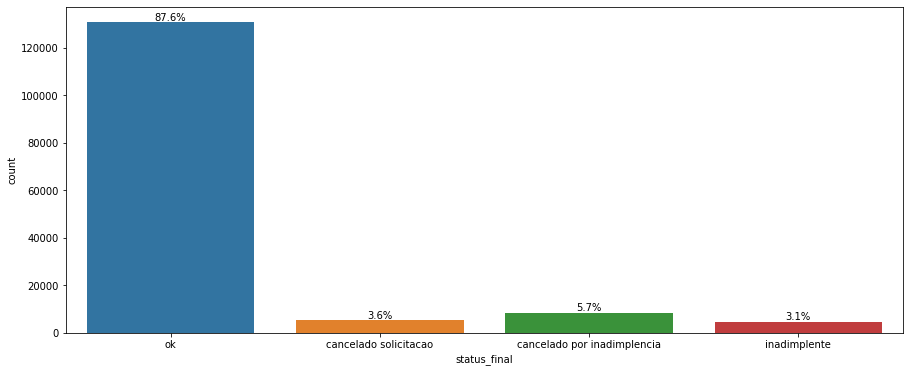

In [35]:
serie_filtrada = df["status_final"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


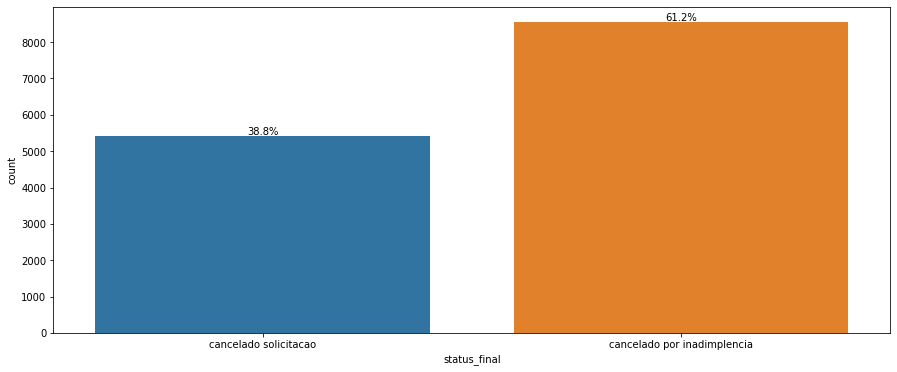

In [36]:
serie_filtrada = df[df["churn"] == 1]["status_final"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Possui Midia Ativa (pode ter influencia no churn, mas muito pouco)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


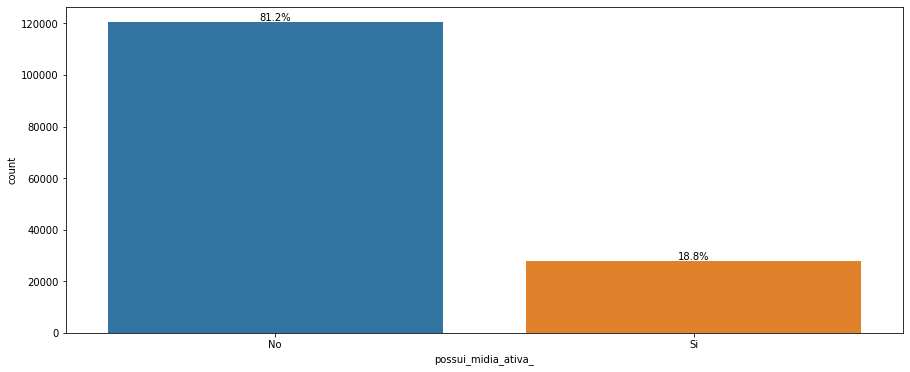

In [37]:
serie_filtrada = df["possui_midia_ativa_"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


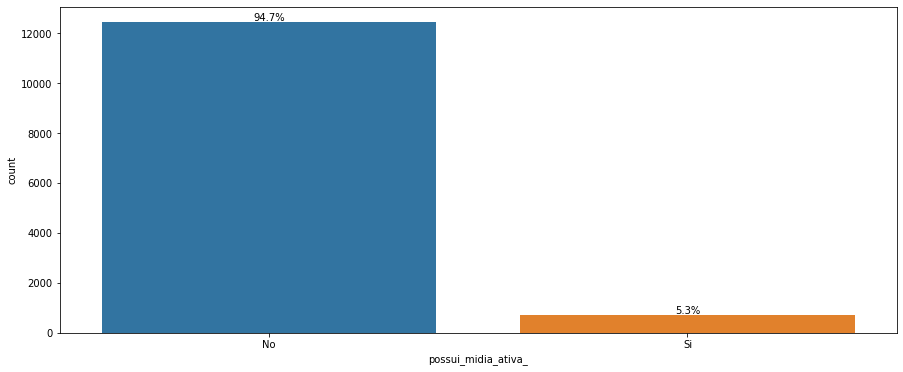

In [38]:
serie_filtrada = df[df["churn"] == 1]["possui_midia_ativa_"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Pessoa Física Jurídica (relação forte com o churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


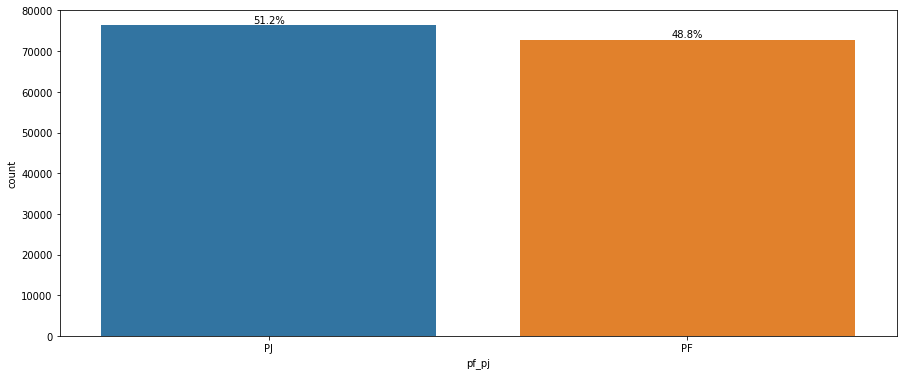

In [39]:
serie_filtrada = df["pf_pj"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


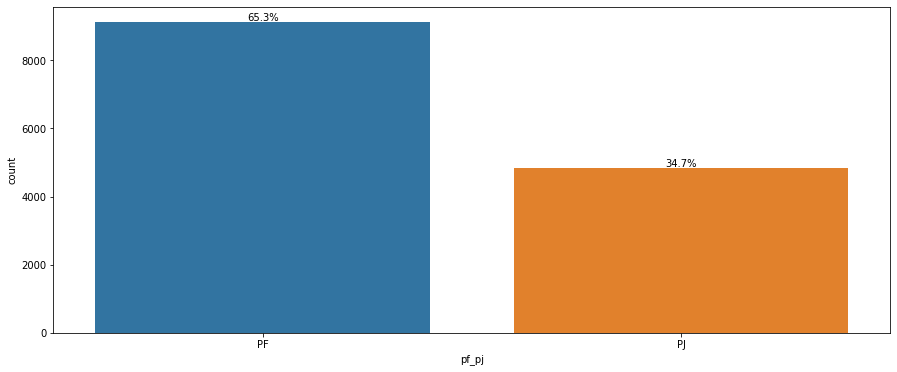

In [40]:
serie_filtrada = df[df["churn"] == 1]["pf_pj"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Faixa Listings (relação forte com o churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


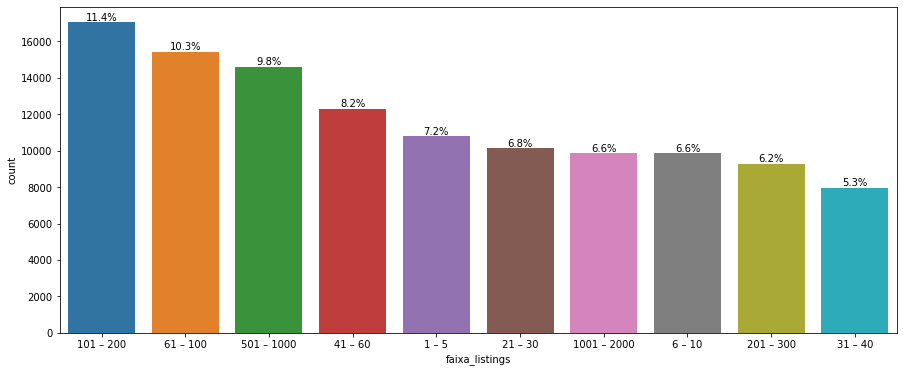

In [41]:
serie_filtrada = df["faixa_listings"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


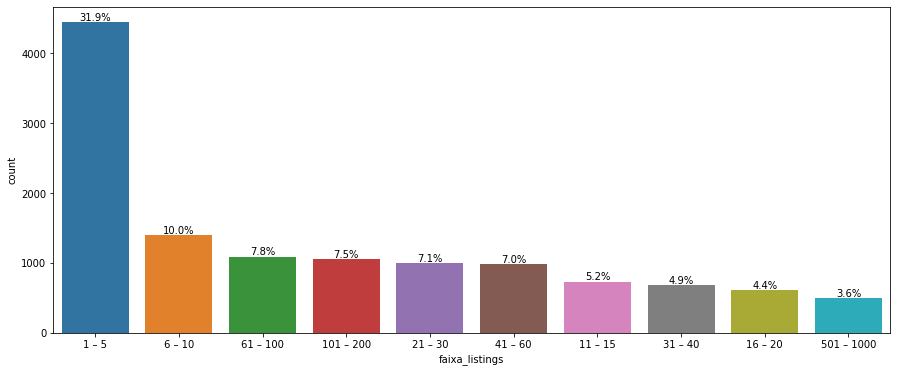

In [42]:
serie_filtrada = df[df["churn"] == 1]["faixa_listings"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

Template

### Análise Valor Mensal (pode influenciar no churn, mas pouco)

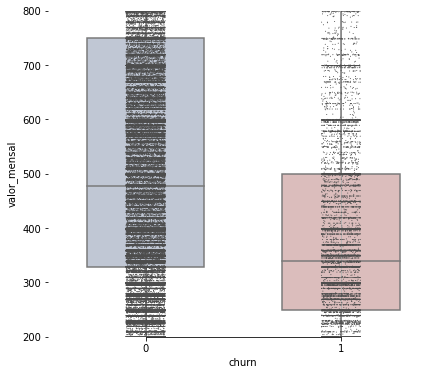

In [43]:
coluna_medida = "valor_mensal"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((200, 800))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Valor Hoje (alta correlação com churn. Talvez seja melhor remover)

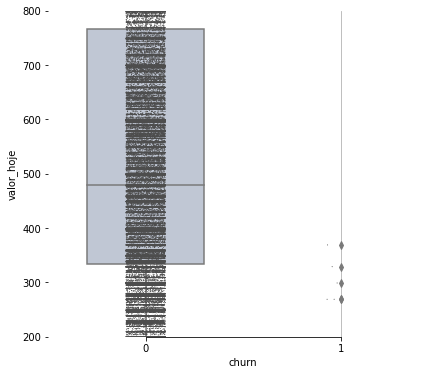

In [44]:
coluna_medida = "valor_hoje"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((200, 800))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Faturamento (Alta correlação com churn. Talvez seja melhor tirar)

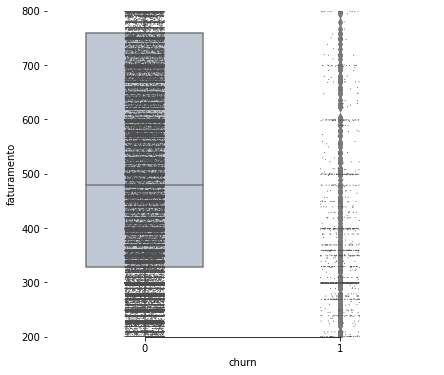

In [45]:
coluna_medida = "faturamento"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((200, 800))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Contratado Super Destaques (pode influenciar no churn)

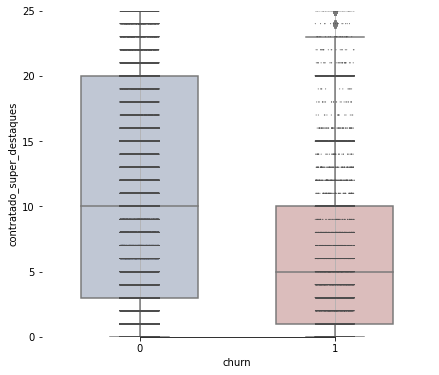

In [46]:
coluna_medida = "contratado_super_destaques"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Contratado Destaques (não aparenta influenciar no churn)

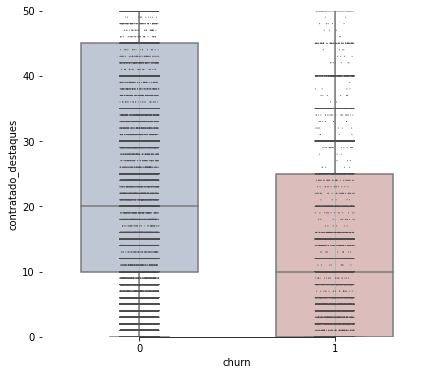

In [47]:
coluna_medida = "contratado_destaques"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 50))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Contratado Ofertas Simples (Relação forte com o churn)

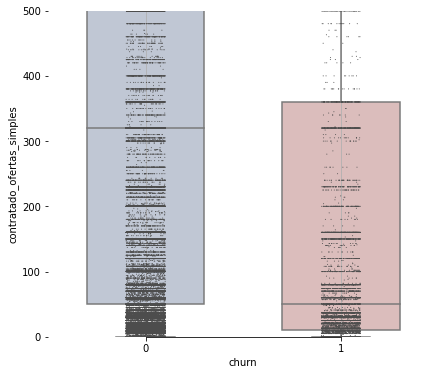

In [48]:
coluna_medida = "contratado_ofertas_simples"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 500))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Utilizado Super Destaque (pode influenciar o churn)

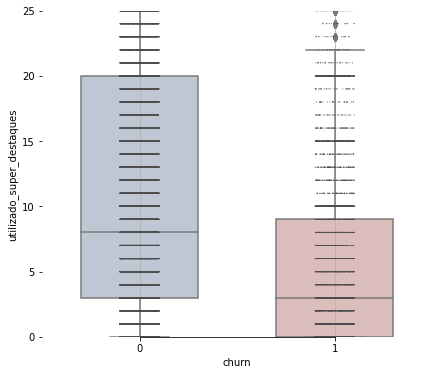

In [49]:
coluna_medida = "utilizado_super_destaques"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Utilizado Destaque (pode influenciar o churn)

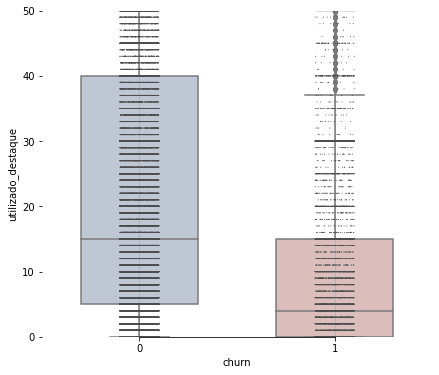

In [50]:
coluna_medida = "utilizado_destaque"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 50))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Utilizado Ofertas Simples (Relação forte com o churn)

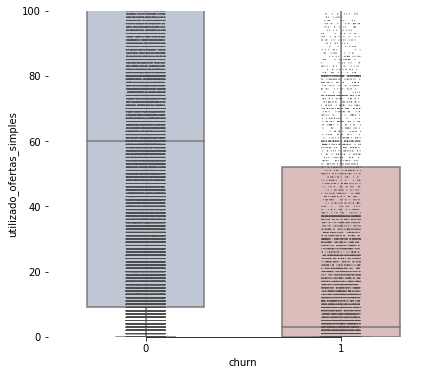

In [51]:
coluna_medida = "utilizado_ofertas_simples"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 100))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Leads Form (Relação forte com o churn)

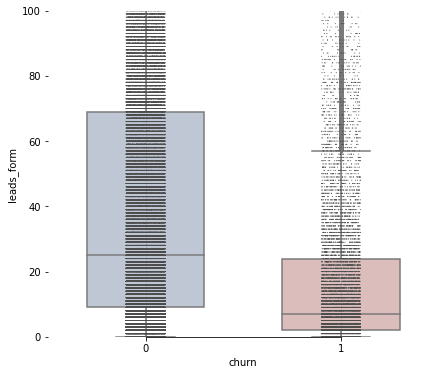

In [52]:
coluna_medida = "leads_form"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 100))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Leads Ver Dato (Relação forte com o churn)

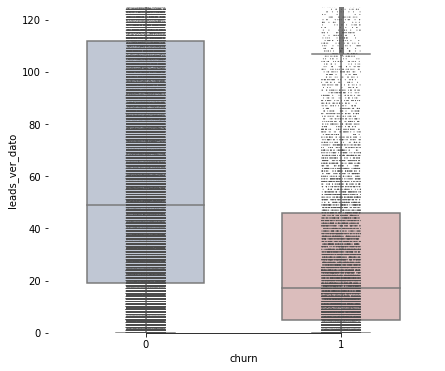

In [53]:
coluna_medida = "leads_ver_dato"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 125))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Leads Total (Relação forte com o churn)

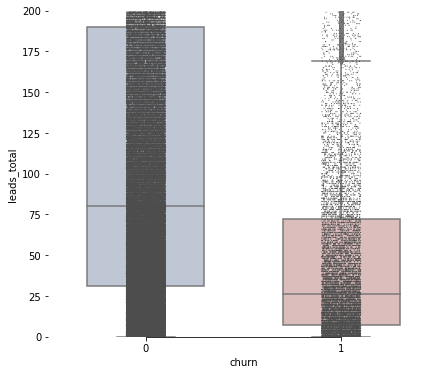

In [54]:
coluna_medida = "leads_total"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 200))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Custo Por Lead Total (Alta correlação com churn. Talvez seja melhor remover)

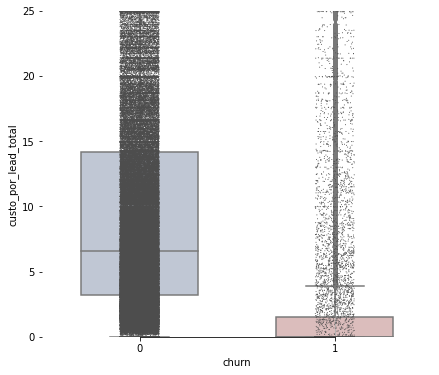

In [55]:
coluna_medida = "custo_por_lead_total"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Total Contratado (Relação fortíssima com o churn)

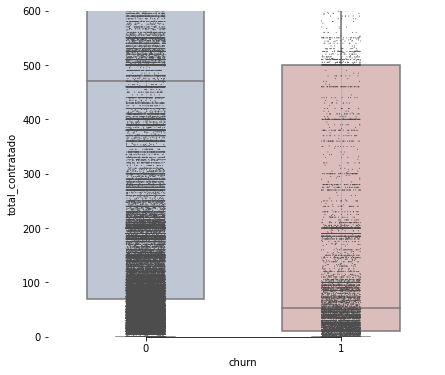

In [56]:
coluna_medida = "total_contratado"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 600))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Total de Listings (Relação forte com o churn)

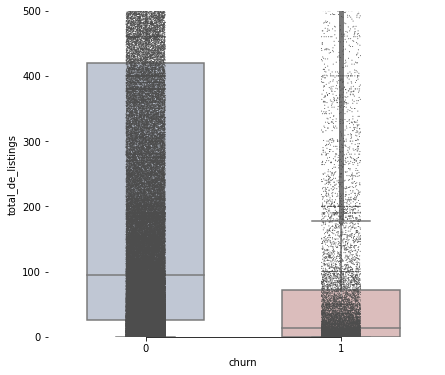

In [57]:
coluna_medida = "total_de_listings"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 500))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Custo Por Listing (Alta correlação com churn. Talvez seja melhor remover)

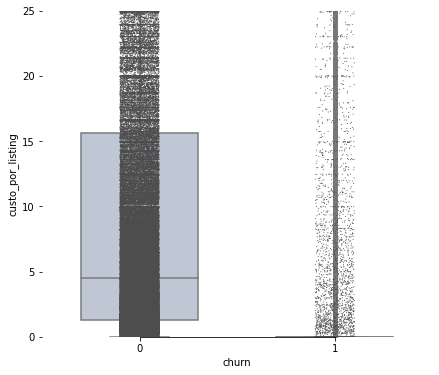

In [58]:
coluna_medida = "custo_por_listing"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Total Utilizado (Relação fortíssima com o churn)

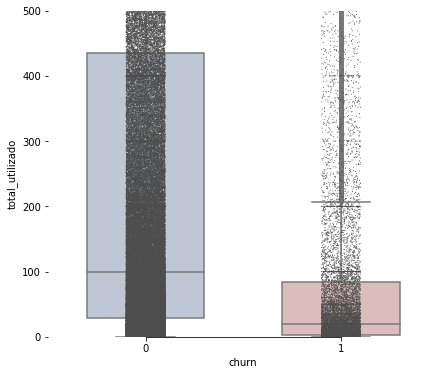

In [59]:
coluna_medida = "total_utilizado"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 500))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

## Outros

### Em um primeiro momento, iremos substituir todos os valores faltantes pelas medianas de cada série

In [60]:
df.isna().sum()

mes                               0
id_crm                            0
id_navplat                        0
id_sap                            0
regiao                            0
cidade                            2
bairro                        51735
valor_mensal                      0
valor_hoje                        0
faturamento                       0
oficina                           0
frequencia_de_faturamento       692
tipo_de_plano                  3581
contratado_super_destaques        0
contratado_destaques              0
contratado_ofertas_simples        0
utilizado_super_destaques         2
utilizado_destaque                2
utilizado_ofertas_simples         2
executivo_carteira_atual          0
equipe                            0
status_final                      0
possui_midia_ativa_             875
leads_form                       32
leads_ver_dato                   34
leads_total                     183
custo_por_lead_total            526
total_contratado            

### Criação de novo dataframe com somente as colunas relevantes

In [61]:
# pode influenciar tanto que talvez seja melhor remover:
# status_final, valor_hoje, faturamento, custo_por_lead_total, custo_por_listing

# pode influenciar muito:
# pf_pj, faixa_listings, contratado_ofertas_simples, utilizado_ofertas_simples,
# leads_form, leads_ver_dato, leads_total, total_contratado, total_de_listings,
# total_utilizado

# pode influenciar:
# tipo_de_plano, equipe, contratado_super_destaques, utilizado_super_destaques, 
# utilizado_destaque

# pode influenciar pouco:
# possui_midia_ativa_, valor_mensal

In [62]:
df = df[['pf_pj', 'contratado_ofertas_simples', 'utilizado_ofertas_simples',
'leads_form', 'leads_ver_dato', 'leads_total', 'total_contratado', 'total_de_listings',
'total_utilizado', 'equipe', 'contratado_super_destaques', 'utilizado_super_destaques', 
'utilizado_destaque', 'valor_mensal', 'churn']].copy()

In [63]:
df = df.fillna(df.median())

/tmp/ipykernel_3874/3493596106.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.median())


In [64]:
df.dtypes

pf_pj                          object
contratado_ofertas_simples      int64
utilizado_ofertas_simples     float64
leads_form                    float64
leads_ver_dato                float64
leads_total                   float64
total_contratado              float64
total_de_listings               int64
total_utilizado               float64
equipe                         object
contratado_super_destaques      int64
utilizado_super_destaques     float64
utilizado_destaque            float64
valor_mensal                  float64
churn                           int64
dtype: object

In [65]:
df.isna().sum()

pf_pj                         0
contratado_ofertas_simples    0
utilizado_ofertas_simples     0
leads_form                    0
leads_ver_dato                0
leads_total                   0
total_contratado              0
total_de_listings             0
total_utilizado               0
equipe                        0
contratado_super_destaques    0
utilizado_super_destaques     0
utilizado_destaque            0
valor_mensal                  0
churn                         0
dtype: int64

### Plot do gráfico para remover as maiores correlações

<AxesSubplot:>

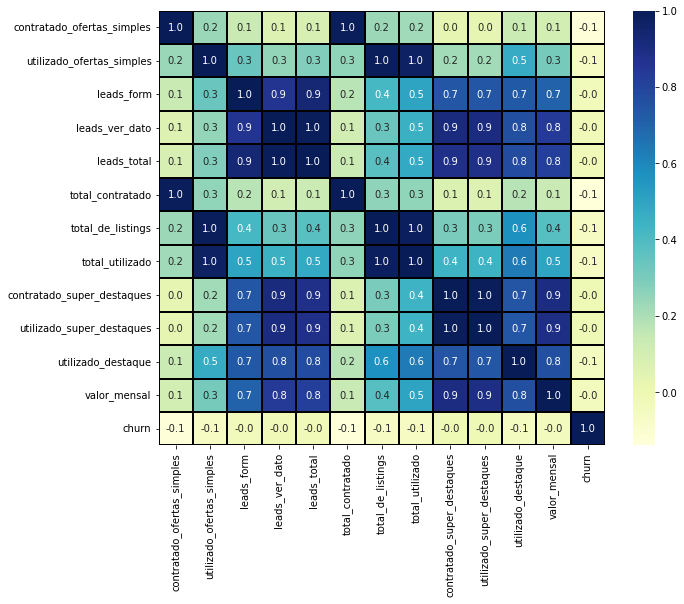

In [66]:
corr = df.corr()

plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f", linecolor="black", linewidths="0.1", )

### Remoção das colunas 'total_de_listings', 'utilizado_super_destaques', 'leads_form', 'leads_ver_dato', 'contratado_ofertas_simples', 'utilizado_ofertas_simples' (devido a alta correlação entre as variáveis)

In [67]:
df = df[['pf_pj', 'leads_total', 'total_contratado', 'total_utilizado', 'equipe', 'contratado_super_destaques', 'utilizado_destaque', 'valor_mensal', 'churn']].copy()

<AxesSubplot:>

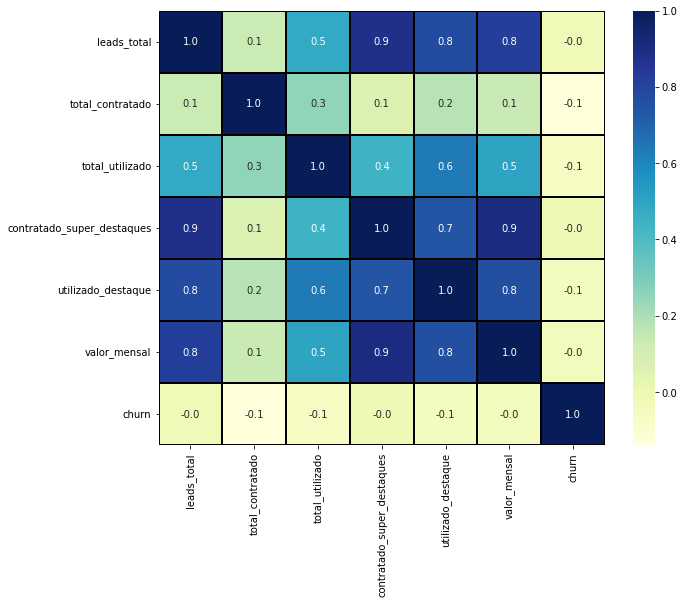

In [68]:
corr = df.corr()

plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f", linecolor="black", linewidths="0.1", )

### Isolar a variável de churn (target)

In [69]:
dfChurn = df['churn']

In [70]:
dfChurn.head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

### Dumificação de variáveis numéricas

In [71]:
dfCategorical = pd.get_dummies(df.select_dtypes(include=['object']), columns=['pf_pj', 'equipe'])

In [72]:
dfCategorical.head()

,pf_pj_PF,pf_pj_PJ,equipe_JUMBO,equipe_Mídias,equipe_REGIONAL DF,equipe_RELACIONAMENTO,equipe_RESELLERS,equipe_Regional DF
0,0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1
4,0,1,0,0,0,0,0,1


### Normalização das variáveis numéricas

In [73]:
Scaler = MinMaxScaler()

dfNumerical = df.select_dtypes(include=np.number).drop(['churn'], axis = 1)
model = Scaler.fit(dfNumerical)
dfNumerical = pd.DataFrame(model.transform(dfNumerical), columns=dfNumerical.columns)


In [74]:
dfNumerical.head()

,leads_total,total_contratado,total_utilizado,contratado_super_destaques,utilizado_destaque,valor_mensal
0,0.000928,0.000167,0.000086,0.000000,0.00000,0.001758
1,0.000951,0.000083,0.000067,0.000000,0.00000,0.001263
2,0.005323,0.033433,0.000638,0.000022,0.00303,0.007280
3,0.003306,0.033530,0.001371,0.000658,0.00303,0.016019
4,0.001020,0.000667,0.000295,0.000000,0.00000,0.002287


### Concatenação das variáveis normalizadas, dumificadas e da variável target

In [75]:
df = pd.concat([dfNumerical, dfCategorical, dfChurn], axis = 1)

In [76]:
df.head()

,leads_total,total_contratado,total_utilizado,contratado_super_destaques,utilizado_destaque,valor_mensal,pf_pj_PF,pf_pj_PJ,equipe_JUMBO,equipe_Mídias,equipe_REGIONAL DF,equipe_RELACIONAMENTO,equipe_RESELLERS,equipe_Regional DF,churn
0,0.000928,0.000167,0.000086,0.000000,0.00000,0.001758,0,1,0,0,0,0,0,1,0
1,0.000951,0.000083,0.000067,0.000000,0.00000,0.001263,1,0,0,0,0,0,0,1,0
2,0.005323,0.033433,0.000638,0.000022,0.00303,0.007280,0,1,0,0,0,0,0,1,0
3,0.003306,0.033530,0.001371,0.000658,0.00303,0.016019,0,1,0,0,0,0,0,1,0
4,0.001020,0.000667,0.000295,0.000000,0.00000,0.002287,0,1,0,0,0,0,0,1,0


### Testes com algorítmos executados manualmente

#### Divisão do dataset em treino e teste e validação

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['churn'], axis=1), df['churn'], test_size=0.2, random_state=1)

#### Execução do modelo

In [78]:
modelLR = LogisticRegression()
modelLR.fit(X_train, y_train)

modelRF = RandomForestClassifier()
modelRF.fit(X_train, y_train)

modelGB = GradientBoostingClassifier()
modelGB.fit(X_train, y_train)


GradientBoostingClassifier()

#### Resultados do modelo

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score: 47.53%
Accuracy Score: 90.57%
Precision Score: 0.0%
Recall Score: 0.0%


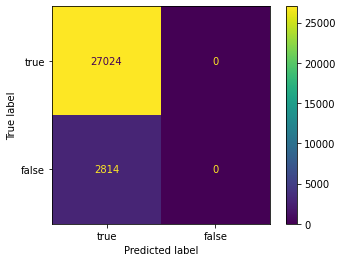

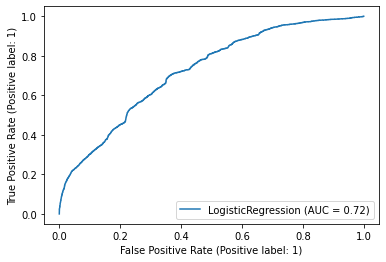

In [118]:
predictLR = modelLR.predict(X_test)

f1 = round(f1_score(y_test, predictLR, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predictLR)*100, 2)
precision = round(precision_score(y_test, predictLR)*100, 2)
recall = round(recall_score(y_test, predictLR)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas = {}
metricas["LogisticRegression"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelLR, X_test, y_test, display_labels=[
                      "true", "false"], values_format="d")
plt.grid(False)
plt.show()

plot_roc_curve(modelLR, X_test, y_test)
plt.show()


F1 Score: 74.38%
Accuracy Score: 93.03%
Precision Score: 73.48%
Recall Score: 40.87%


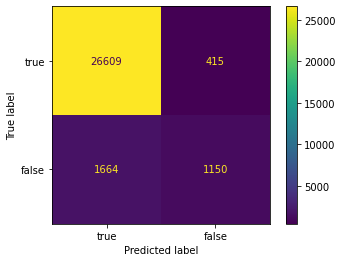

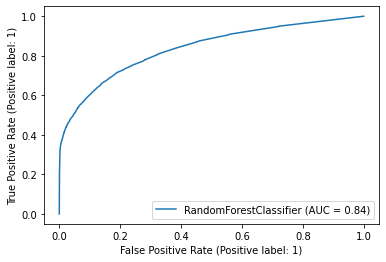

In [119]:
predictRF = modelRF.predict(X_test)

f1 = round(f1_score(y_test, predictRF, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predictRF)*100, 2)
precision = round(precision_score(y_test, predictRF)*100, 2)
recall = round(recall_score(y_test, predictRF)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas["RandomForest"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelRF, X_test, y_test, display_labels=[
                      "true", "false"], values_format="d")
plt.grid(False)
plt.show()

plot_roc_curve(modelRF, X_test, y_test)
plt.show()


F1 Score: 74.69%
Accuracy Score: 93.69%
Precision Score: 89.61%
Recall Score: 37.38%


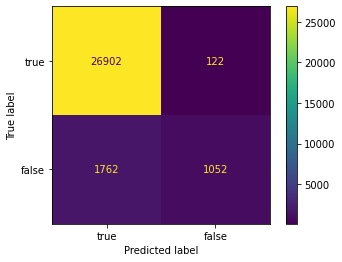

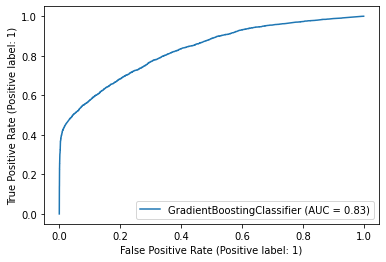

In [120]:
predictGB = modelGB.predict(X_test)

f1 = round(f1_score(y_test, predictGB, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predictGB)*100, 2)
precision = round(precision_score(y_test, predictGB)*100, 2)
recall = round(recall_score(y_test, predictGB)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas["GradientBoosting"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelGB, X_test, y_test, display_labels=[
                      "true", "false"], values_format="d")
plt.grid(False)
plt.show()

plot_roc_curve(modelGB, X_test, y_test)
plt.show()


1. Realizar o tunning de hiperparâmetros
2. Realizar cross validation
3. Verificar a preferência do cliente em relação a falsos positivos e falsos negativos
4. Verificar a interpretabilidade dos modelos


In [122]:
resumo = pd.DataFrame.from_dict(metricas, orient='index')
resumo


,accuracy,precision,recall,f1
LogisticRegression,90.57,0.00,0.00,47.53
RandomForest,93.03,73.48,40.87,74.38
GradientBoosting,93.69,89.61,37.38,74.69


In [94]:
parameters = {
    "n_estimators": [5, 50, 250, 500],
    "max_depth": [1, 3, 5, 7, 9],
    "learning_rate": [0.01, 0.1, 1, 10]
}

bayes_search = BayesSearchCV(modelGB, search_spaces=parameters, cv=3, n_jobs=-1, verbose=2)
bayes_search.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....learning_rate=1.0, max_depth=9, n_estimators=50; total time=  16.1s
[CV] END ....learning_rate=1.0, max_depth=9, n_estimators=50; total time=  16.4s
[CV] END ....learning_rate=1.0, max_depth=9, n_estimators=50; total time=  14.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....learning_rate=1.0, max_depth=3, n_estimators=50; total time=   5.6s
[CV] END ....learning_rate=1.0, max_depth=3, n_estimators=50; total time=   5.7s
[CV] END ....learning_rate=1.0, max_depth=3, n_estimators=50; total time=   5.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  11.8s
[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  11.8s
[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  10.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ...learning_rate=10.0, max

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=500; total time= 2.4min
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=500; total time= 2.4min
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=500; total time= 2.2min


/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=500; total time= 2.0min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=500; total time= 2.0min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=500; total time= 1.6min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....learning_rate=0.1, max_depth=9, n_estimators=50; total time=  15.3s
[CV] END ....learning_rate=0.1, max_depth=9, n_estimators=50; total time=  15.3s
[CV] END ....learning_rate=0.1, max_depth=9, n_estimators=50; total time=  13.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ...learning_rate=1.0, max_depth=5, n_estimators=500; total time= 1.4min
[CV] END ...learning_rate=1.0, max_depth=5, n_estimators=500; total time= 1.5min
[CV] END ...learning_rate=1.0, max_depth=5, n_estimators=500; total time= 1.2min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....learning_rate=1.0, max

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  11.6s
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  11.8s
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  10.2s


/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  15.3s
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  15.6s
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  16.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....learning_rate=0.01, max_depth=9, n_estimators=5; total time=   2.1s
[CV] END ....learning_rate=0.01, max_depth=9, n_estimators=5; total time=   2.1s
[CV] END ....learning_rate=0.01, max_depth=9, n_estimators=5; total time=   1.6s


/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=500; total time= 2.2min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=500; total time= 2.3min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=500; total time= 1.8min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   2.4s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   2.5s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   2.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=250; total time=  11.4s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=250; total time=  11.7s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=250; total time=   9.5s


/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=250; total time=  44.7s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=250; total time=  45.7s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=250; total time=  38.4s


BayesSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
              search_spaces={'learning_rate': [0.01, 0.1, 1, 10],
                             'max_depth': [1, 3, 5, 7, 9],
                             'n_estimators': [5, 50, 250, 500]},
              verbose=2)

In [95]:
bayes_search.best_params_
# Results: OrderedDict([('learning_rate', 0.1), ('max_depth', 7), ('n_estimators', 50)])


OrderedDict([('learning_rate', 0.1), ('max_depth', 7), ('n_estimators', 50)])

In [96]:
bayes_search.best_estimator_
# Results: GradientBoostingClassifier(max_depth=7, n_estimators=50)


GradientBoostingClassifier(max_depth=7, n_estimators=50)

F1 Score: 76.31%
Accuracy Score: 94.0%
Precision Score: 91.29%
Recall Score: 40.23%


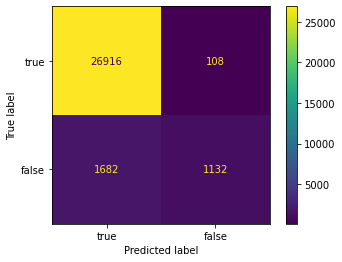

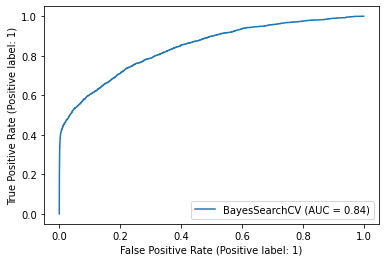

In [ ]:
y_pred = bayes_search.predict(X_test)

f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
precision = round(precision_score(y_test, y_pred)*100, 2)
recall = round(recall_score(y_test, y_pred)*100, 2)


print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas = {}
metricas["GradientBoosting"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(bayes_search, X_test, y_test, display_labels=[
                      "true", "false"], values_format="d")
                      
plt.grid(False)
plt.show()

plot_roc_curve(bayes_search, X_test, y_test)
plt.show()


In [131]:
parametros = {
    'max_depth': [100, 150],
    'max_features': [3, 4, 5],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 8, 10],
    'n_estimators': [200, 300, 400]
}

bayes_search = BayesSearchCV(estimator=modelRF, search_spaces=parametros, n_jobs=-1, cv=3, verbose=2)
bayes_search.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criterion=entropy, max_depth=134, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time= 1.1min
[CV] END criterion=entropy, max_depth=134, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time= 1.1min
[CV] END criterion=entropy, max_depth=134, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time= 1.1min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criterion=entropy, max_depth=133, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time= 1.3min
[CV] END criterion=entropy, max_depth=133, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time= 1.3min
[CV] END criterion=entropy, max_depth=133, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=  42.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criterion=gini, max_depth=101, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  54.2s
[CV] END criterion=gini, max_depth=101, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  55.4s
[CV] END criterion=gini, max_depth=101, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  52.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criterion=gini, max_depth=102, max_features=3, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=  19.9s
[CV] END criterion=gini, max_depth=102, max_features=3, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=  20.0s
[CV] END criterion=gini, max_depth=102, max_features=3, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=  18.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criteri

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criterion=gini, max_depth=100, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  28.3s
[CV] END criterion=gini, max_depth=100, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  28.6s
[CV] END criterion=gini, max_depth=100, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  26.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criterion=gini, max_depth=109, max_features=3, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=  20.2s
[CV] END criterion=gini, max_depth=109, max_features=3, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=  20.3s
[CV] END criterion=gini, max_depth=109, max_features=3, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time=  19.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criteri

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criterion=gini, max_depth=101, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  57.0s
[CV] END criterion=gini, max_depth=101, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  57.8s
[CV] END criterion=gini, max_depth=101, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  57.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criterion=gini, max_depth=145, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=  41.5s
[CV] END criterion=gini, max_depth=145, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=  41.6s
[CV] END criterion=gini, max_depth=145, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=  39.1s


/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criterion=gini, max_depth=100, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  58.7s
[CV] END criterion=gini, max_depth=100, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  58.7s
[CV] END criterion=gini, max_depth=100, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  52.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criterion=entropy, max_depth=139, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=  31.5s
[CV] END criterion=entropy, max_depth=139, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=  31.6s
[CV] END criterion=entropy, max_depth=139, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=  28.0s


BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [100, 150], 'max_features': [3, 4, 5],
                             'min_samples_leaf': [1, 2, 3],
                             'min_samples_split': [2, 3, 8, 10],
                             'n_estimators': [200, 300, 400]},
              verbose=2)

In [132]:
bayes_search.best_params_
# Results: OrderedDict([('criterion', 'entropy'), ('max_depth', 150), ('max_features', 5), ('min_samples_leaf', 2), ('min_samples_split', 10), ('n_estimators', 300)])


OrderedDict([('criterion', 'entropy'),
             ('max_depth', 150),
             ('max_features', 5),
             ('min_samples_leaf', 2),
             ('min_samples_split', 10),
             ('n_estimators', 300)])

In [133]:
bayes_search.best_estimator_
# Results: RandomForestClassifier(criterion='entropy', max_depth=150, max_features=5, min_samples_leaf = 2, min_samples_split = 10, n_estimators = 300)


RandomForestClassifier(criterion='entropy', max_depth=150, max_features=5,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=300)

F1 Score: 76.19%
Accuracy Score: 93.95%
Precision Score: 90.26%
Recall Score: 40.19%


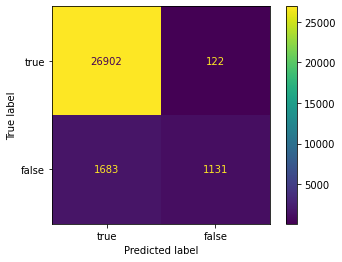

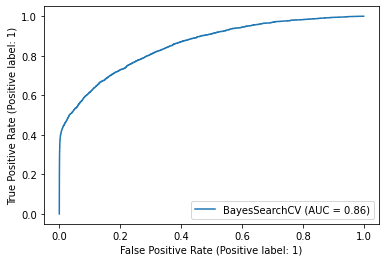

In [134]:
y_pred = bayes_search.predict(X_test)

f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
precision = round(precision_score(y_test, y_pred)*100, 2)
recall = round(recall_score(y_test, y_pred)*100, 2)


print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas = {}
metricas["RandomForest"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(bayes_search, X_test, y_test, display_labels=[
                      "true", "false"], values_format="d")

plt.grid(False)
plt.show()

plot_roc_curve(bayes_search, X_test, y_test)
plt.show()


In [138]:
resumo = pd.DataFrame.from_dict(metricas, orient='index')
resumo


,accuracy,precision,recall,f1
RandomForest,93.95,90.26,40.19,76.19
GradientBoosting,94.0,91.29,40.23,76.31


In [139]:
clf = modelGB

In [142]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                                                   feature_names=X_train.columns,
                                                   class_names=[
                                                       "Não Churn", "Churn"],
                                                   mode='classification')


In [143]:
exp = explainer.explain_instance(X_test.iloc[25],
                                 clf.predict_proba,
                                 num_features=8,
                                 top_labels=1)


In [144]:
exp.show_in_notebook(show_table=True, show_all=False)


In [145]:
X_test.iloc[25]


leads_total                   0.003175
total_contratado              0.000387
total_utilizado               0.000895
contratado_super_destaques    0.000132
utilizado_destaque            0.001010
valor_mensal                  0.004857
pf_pj_PF                      1.000000
pf_pj_PJ                      0.000000
equipe_JUMBO                  0.000000
equipe_Mídias                 0.000000
equipe_REGIONAL DF            0.000000
equipe_RELACIONAMENTO         0.000000
equipe_RESELLERS              0.000000
equipe_Regional DF            1.000000
Name: 17039, dtype: float64

In [146]:
y_test.iloc[25]


0